## Test two GLMM algorithms 

In [71]:
using Revise, DelimitedFiles

In [72]:
using Pkg
Pkg.activate(homedir()*"/GIT/susie-glmm/SuSiEGLMM.jl")

  Activating project at `~/GIT/susie-glmm/SuSiEGLMM.jl`


In [73]:
@__DIR__

"/Users/jeankim/GIT/susie-glmm/SuSiEGLMM.jl/test"

In [74]:
using Statistics, Distributions, StatsBase, Random, LinearAlgebra, Distributed,GLM

In [75]:
using SuSiEGLMM

In [76]:
#genotype matrix and impute missing values
@time geno=readdlm(homedir()*"/GIT/SuSiEGLMM.jl/testdata/causal1/pop/ascertained_pop_genotype_12_10.txt";header=true);

X = geno[1][:,6:end]

for j =axes(X,2)
    idx = findall(X[:,j].=="NA")
    X[idx,j].= missing
    X[idx,j] .= mean(skipmissing(X[:,j]))
end

  1.018578 seconds (18.07 M allocations: 513.189 MiB, 19.04% gc time, 2.16% compilation time)


In [77]:
# pedgree grm and grm
K=readdlm(homedir()*"/GIT/SuSiEGLMM.jl/testdata/causal1/pop/pop_grm_ped.txt"); #518
K0=readdlm(homedir()*"/GIT/SuSiEGLMM.jl/testdata/causal1/pop/pop_grm.txt");
K0=Symmetric(K0);K0=convert(Matrix{Float64}, K0);

In [78]:
Seed(124)

## Sampling one dataset for comparison

In [79]:
X1= (X.-mean(X,dims=2))./std(X,dims=2)
n,p = size(X1)
L=1; B=1;
tol=1e-4
b_true=zeros(p);
b_1s=zeros(B); 

# Ts=zeros(p,B);Ts1=zeros(p,B);

In [80]:
(n,p)

(503, 4000)

In [81]:
τ2=1.0; #true value

# res0=[]; res1=[]

# K=Matrix(1.0I,n,n)
# T,S = svdK(K;LOCO=false) #pedigree
T,S = svdK(K0;LOCO=false) #grm

([-0.03009495162366858 -0.031199170200303952 … 0.02250555702743749 -0.032300622574000716; 0.018922699570053384 -0.011274405950787193 … -0.08587528642298964 -0.06720273463442801; … ; 0.030711943755013932 -0.08417309847479863 … 0.001685475850207202 -0.02001944231048721; -0.044587796206770926 -0.0445877962067711 … -0.04458779620677096 -0.04458779620677122], [1.8498635657424751, 1.8261737315279054, 1.8023586994816634, 1.795369895112748, 1.7886748954597398, 1.77722900960392, 1.76599079160014, 1.7489955943284636, 1.7484990825208595, 1.73815229501913  …  0.4543734391818463, 0.45258719285154625, 0.4482105576406595, 0.4445639720846187, 0.44317598472484143, 0.438904667753285, 0.43267495350217544, 0.4293582332306149, 0.4197027678053472, 1.7510186732697898e-15])

## GLMM (no integration out of fixed effects but corrected version)

In [82]:
# data preparation

#for j = 1:B
    b_true[1]= randn(1)[1] 
#     b_1s[j] = b_true[1]   
   
#     X=randn(n,p)
#     g=rand(MvNormal(τ2*K)) #pedigree grm
    g=rand(MvNormal(τ2*K0)) #grm
    
    #generating binary outcome
    Y= logistic.(g) .>rand(n); Y=convert(Vector{Float64},Y);
    Y1=logistic.(X1*b_true+g) .>rand(n);  Y1=convert(Vector{Float64},Y1);
       
    X₀=ones(n,1);

In [83]:
   
   # transforming data         
     Xt, Xt₀, y0 = SuSiEGLMM.rotate(Y,X1,X₀,T)   
       y1= SuSiEGLMM.rotateY(Y1,T)

#initialization
    τ² =2.0.^[-10:0.5:2.5;] # the range of τ²
  

26-element Vector{Float64}:
 0.0009765625
 0.0013810679320049757
 0.001953125
 0.0027621358640099515
 0.00390625
 0.005524271728019903
 0.0078125
 0.011048543456039806
 0.015625
 0.02209708691207961
 ⋮
 0.3535533905932738
 0.5
 0.7071067811865476
 1.0
 1.4142135623730951
 2.0
 2.8284271247461903
 4.0
 5.656854249492381

In [84]:
b_true[1] # true b

-0.6680014719649068

In [59]:
#     for j in eachindex(τ²)
#      f=open(joinpath(@__DIR__,"glmm_est_$(τ²[j]).txt"),"w")
      
#         β0 = glm(X₀,Y,Binomial()) |> coef
#         ξ0 =sqrt.(getXy('N',Xt₀,β0).^2+ τ²[j]*S)
#         res0= emGLMM(y0,Xt₀,S,τ²[j],ξ0;tol=tol) #H0
#     end

In [129]:
glm(X₀,Y1,Binomial()) |> coef #initial β

1-element Vector{Float64}:
 0.21956572898373788

In [131]:
    for j in eachindex(τ²)
   
        β = glm(X₀,Y1,Binomial()) |> coef
        ξ =sqrt.(SuSiEGLMM.getXy('N',Xt₀,β).^2+ τ²[j]*S)

        
        res1= emGLMM(y1,Xt₀,S,τ²[j],ξ;tol=tol) #H1 
           out=readdlm(joinpath(@__DIR__,"glmm_est.txt"))
#            writedlm("glmm_est_$(τ²[j]).txt",out)
            writedlm("glmm_est_$(τ²[j])_grm.txt",out)
#         T0= computeT(res0,y0,Xt₀,Xt)
#         T1= computeT(res1,y1,Xt₀,Xt)
       
    end
        
#printing out # of iterations per case     

396
396
1481
1395
1332
1289
1257
109
439
429
481
475
472
471
470
470
470
470
470
470
470
470
470
470
470
470


### Plots of results when using pedigree K 

The following is all the outputs that track `τ²` and the corresponding `elbo` until convergence at `tol=1e-4` when intial `τ²`values are smaller or closer to the true `τ²` (τ2).   i.e. The smaller or closer (to the true one) the initial values are, the algorithm converges quickly.  This also happens to `the integrated out` glmm.  

In [84]:
#track τ² and the corresponding ELBO for early convergence (max # of iterations to stop: 2)
for j=1:8
    println(readdlm("glmm_est_$(τ²[2j-1]).txt")[:,[2, end]]) 
end

[0.0009765624304588693 -599.6043354131515; 0.0009765623609352599 -599.6043354131509]
[0.0019531245670110129 -599.6043583009778; 0.0019531241341621557 -599.604358300966]
[0.0039062470319848734 -599.6044339337442; 0.003906244065091971 -599.6044339335995]
[0.007812478279908589 -599.604704247401; 0.007812456568869824 -599.6047042454577]
[0.015624834977952487 -599.6057180387395; 0.015624670031267475 -599.6057180107024]
[0.03124872491680569 -599.6096142761623; 0.03124745053691493 -599.6096138577273]
[0.06249013747764906 -599.6246929562564; 0.06248028374636911 -599.6246866991544]
[0.12492484169009832 -599.6825444506499; 0.12484984569336556 -599.682453678602]


In [85]:
using Plots

In [110]:
#pick two initial cases (the next larger and largest): τ²=0.17677, 5.65685
tau16=readdlm("glmm_est_$(τ²[16]).txt")[:,[2, end]];
tau=readdlm("glmm_est_$(τ²[end]).txt")[:,[2, end]];

Regardless of how large from the true `τ²`, they converge to similar final elbo and τ². So does the integration out glmm.

In [114]:
[tau16[end-5:end,:] tau[end-5:end,:]] #print out last values up to convergence

6×4 Matrix{Float64}:
 0.12843   -599.687  0.12839   -599.687
 0.128348  -599.687  0.128308  -599.687
 0.128267  -599.687  0.128227  -599.687
 0.128186  -599.687  0.128146  -599.686
 0.128105  -599.686  0.128066  -599.686
 0.128025  -599.686  0.127985  -599.686

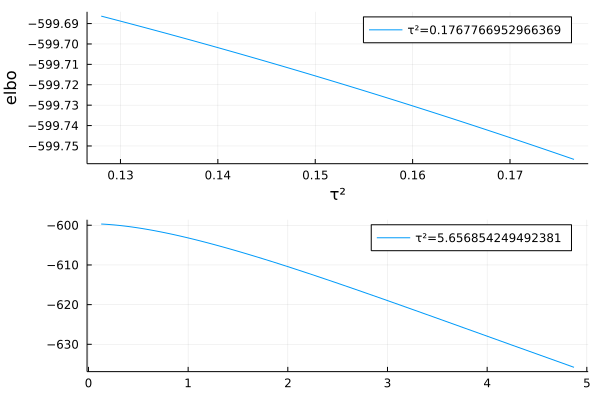

In [97]:
ll=@layout[a ;b]
p1=plot(tau16[:,1],tau16[:,2],label="τ²=$(τ²[16])", xlab="τ²", ylab="elbo")
p2=plot(tau[:,1],tau[:,2],label="τ²=$(τ²[end])")
plot(p1,p2,layout=ll)

### Plots using empirical grm

Regardless of initial values of τ², both elbo and τ² blow out.  

In [149]:
#pick up three initials : τ² = 0.0009765625, 0.125, 5.657
#dropping Inf, NaN
taug1=readdlm("glmm_est_$(τ²[1])_grm.txt")[1:end-2,[2,end]];
taug15=readdlm("glmm_est_$(τ²[15])_grm.txt")[1:end-1,[2,end]];
taug=readdlm("glmm_est_$(τ²[end])_grm.txt")[1:end-1,[2,end]];

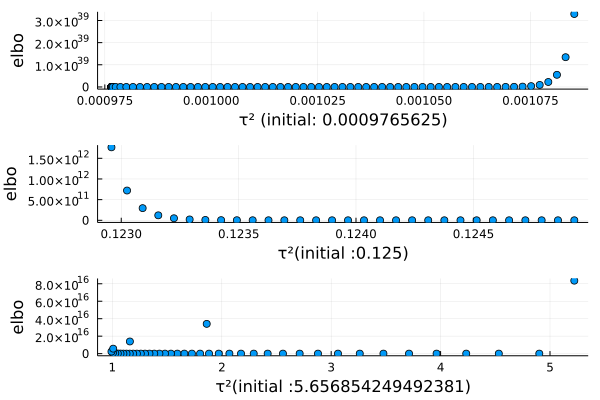

In [183]:
l2=@layout[a; b; c]
pp1=scatter(taug1[1:100,1],taug1[1:100,end],label="",ylab="elbo",xlab="τ² (initial: $(τ²[1]))")
pp2=scatter(taug15[1:30,1],taug15[1:30,end],label="",ylab="elbo",xlab="τ²(initial :$(τ²[15]))")
pp3=scatter(taug[1:42,1],taug[1:42,end],label="",ylab="elbo",xlab="τ²(initial :$(τ²[end]))")
plot(pp1,pp2,pp3,layout=l2)

## GLMM (integration out)

In [87]:


# for j=1:B
#     Xt, Xt₀, yt,init01= initialization(Y,X,ones(n,1),Matrix(1.0I,n,n),ones(n);tol=1e-4)
#     T1= computeT(init01,yt,Xt₀,Xt)
    
         Σ0= 2(cov(Xt₀)+I) # avoid sigularity when only with intercept
     for j in eachindex(τ²)

        sig0=SuSiEGLMM.getXX('N',Σ0,'T',Xt₀)
        β̂0=SuSiEGLMM.getXy('N',sig0,y1)
        ξ0 =sqrt.(SuSiEGLMM.getXy('N',Xt₀,β̂0 ).^2+ Diagonal(SuSiEGLMM.getXX('N',Xt₀,'N',sig0).+τ²[j]*S)*ones(n))
    

        init= SuSiEGLMM.init(y1,Xt₀,S,ξ0,τ²[j],Σ0;tol=tol)
        out1=readdlm(joinpath(@__DIR__,"est_elbocomp.txt"))
#         writedlm("est_elbocomp_$(τ²[j]).txt",out1)
        writedlm("est_elbocomp_$(τ²[j])_grm1.txt",out1)
    end
    
#      init1=[init1;init01]
# init1=[init1;init01]
#       Ts1[:,j]=T1;
# end

8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
65
332
435
483
509
525
535
542
548
555


In [88]:
Σ0;sig0=SuSiEGLMM.getXX('N',Σ0,'T',Xt₀);
        β̂0=SuSiEGLMM.getXy('N',sig0,y1) #initial β̂

1-element Vector{Float64}:
 2.000000000000002

### Plots of results using pedigree K

Here are arrays of all outputs for tracking τ² and elbo such that initial τ² are smaller and closer to the true `τ2=0.1`.  They converge too early for smaller values or quickly for closer value to the true (strictly speaking, slightly larger than the true τ2)

In [89]:
#track τ² and the corresponding elbo for pedigree K
# early convergence up to initial values close to the true one (max # of iterations: 4)
for j=1:8
display(readdlm("est_elbocomp_$(τ²[2j-1]).txt")[:,[1, end]])
end

4×2 Matrix{Float64}:
 0.000976734  -603.98
 0.000976735  -602.916
 0.000976736  -602.916
 0.000976737  -602.916

4×2 Matrix{Float64}:
 0.00195381  -603.979
 0.00195382  -602.916
 0.00195382  -602.916
 0.00195382  -602.916

4×2 Matrix{Float64}:
 0.003909    -603.979
 0.00390901  -602.916
 0.00390902  -602.916
 0.00390903  -602.916

4×2 Matrix{Float64}:
 0.00782348  -603.978
 0.00782354  -602.916
 0.00782356  -602.916
 0.00782358  -602.916

4×2 Matrix{Float64}:
 0.0156689  -603.977
 0.015669   -602.915
 0.015669   -602.915
 0.015669   -602.915

4×2 Matrix{Float64}:
 0.0314251  -603.976
 0.031425   -602.917
 0.0314244  -602.917
 0.0314237  -602.917

4×2 Matrix{Float64}:
 0.0631967  -603.982
 0.0631915  -602.927
 0.0631839  -602.927
 0.0631763  -602.927

4×2 Matrix{Float64}:
 0.127759  -604.024
 0.127699  -602.978
 0.127629  -602.978
 0.12756   -602.978

In [111]:
#pick the next larger τ² from the true and the largest 
# :τ²=0.17677, 5.65685
t16=readdlm("est_elbocomp_$(τ²[16]).txt")[:,[1,end]];
tm=readdlm("est_elbocomp_$(τ²[end]).txt")[:,[1,end]];


In [135]:
[t16[end-5:end,:] tm[end-5:end,:]] #print out last values up to convergence

6×4 Matrix{Float64}:
 0.137305  -602.988  0.137277  -602.988
 0.137219  -602.988  0.13719   -602.988
 0.137132  -602.988  0.137103  -602.988
 0.137045  -602.988  0.137017  -602.988
 0.136959  -602.988  0.13693   -602.988
 0.136873  -602.988  0.136844  -602.988

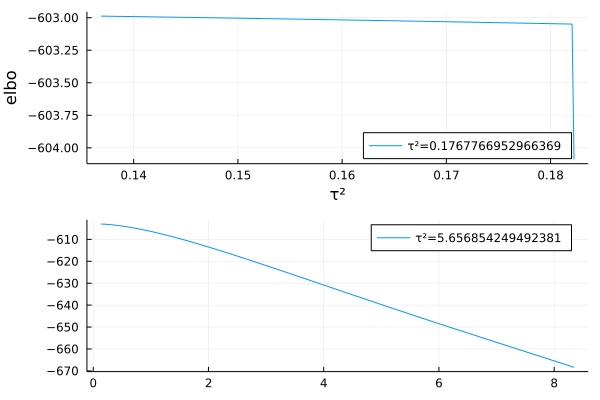

In [108]:
ll=@layout[a ;b]
p3=plot(t16[:,1],t16[:,2],label="τ²=$(τ²[16])", xlab="τ²", ylab="elbo",legend=:bottomright)
p4=plot(tm[:,1],tm[:,2],label="τ²=$(τ²[end])")
plot(p3,p4,layout=ll)

### Plots using empirical grm

Just as results from using the pedigree K, regardless of initial values of `τ²`, all elbo's converge to the almost similar final values. 

Sufficiently large initial τ²'s or ones slightly larger ones than the true dramatically dropped down to min and started to reach the max ELBO.  ELBO decreases small initial values when approaching to the true small `τ2`.  
On the other hand, regardless of initial values, ELBO increases for the large true `τ2=1` ignoring its estimation  accuracy.

In [90]:
#print out last several ouputs of τ²'s and elbo's for small initial τ² less than the true τ2=0.1
for j=2:14
    display(readdlm("est_elbocomp_$(τ²[j])_grm1.txt")[:,[1,end]])
end

7×2 Matrix{Float64}:
 0.00138108  -605.962
 0.0013811   -603.584
 0.00138112  -603.224
 0.00138113  -603.177
 0.00138115  -603.172
 0.00138116  -603.172
 0.00138118  -603.172

7×2 Matrix{Float64}:
 0.00195316  -605.96
 0.00195319  -603.582
 0.00195322  -603.223
 0.00195325  -603.176
 0.00195328  -603.171
 0.00195332  -603.171
 0.00195335  -603.171

7×2 Matrix{Float64}:
 0.0027622   -605.959
 0.00276226  -603.581
 0.00276233  -603.221
 0.00276239  -603.174
 0.00276245  -603.169
 0.00276252  -603.169
 0.00276258  -603.169

7×2 Matrix{Float64}:
 0.00390638  -605.956
 0.0039065   -603.578
 0.00390663  -603.219
 0.00390675  -603.172
 0.00390688  -603.167
 0.00390701  -603.166
 0.00390713  -603.166

7×2 Matrix{Float64}:
 0.00552452  -605.953
 0.00552477  -603.575
 0.00552502  -603.215
 0.00552527  -603.168
 0.00552552  -603.164
 0.00552577  -603.163
 0.00552602  -603.163

7×2 Matrix{Float64}:
 0.00781299  -605.948
 0.00781348  -603.57
 0.00781397  -603.211
 0.00781447  -603.164
 0.00781496  -603.159
 0.00781545  -603.158
 0.00781594  -603.158

7×2 Matrix{Float64}:
 0.0110495  -605.942
 0.0110505  -603.564
 0.0110514  -603.204
 0.0110524  -603.157
 0.0110533  -603.152
 0.0110543  -603.152
 0.0110553  -603.152

7×2 Matrix{Float64}:
 0.0156269  -605.933
 0.0156287  -603.555
 0.0156306  -603.195
 0.0156324  -603.148
 0.0156343  -603.143
 0.0156362  -603.143
 0.015638   -603.143

7×2 Matrix{Float64}:
 0.0221006  -605.921
 0.0221042  -603.543
 0.0221077  -603.183
 0.0221113  -603.136
 0.0221148  -603.131
 0.0221183  -603.131
 0.0221219  -603.131

7×2 Matrix{Float64}:
 0.0312566  -605.905
 0.0312632  -603.527
 0.0312698  -603.167
 0.0312764  -603.12
 0.031283   -603.115
 0.0312896  -603.115
 0.0312962  -603.115

7×2 Matrix{Float64}:
 0.044206   -605.884
 0.0442178  -603.506
 0.0442297  -603.146
 0.0442415  -603.099
 0.0442534  -603.094
 0.0442652  -603.094
 0.0442771  -603.094

7×2 Matrix{Float64}:
 0.0625199  -605.858
 0.0625399  -603.48
 0.0625598  -603.12
 0.0625798  -603.073
 0.0625998  -603.069
 0.0626198  -603.068
 0.0626397  -603.068

7×2 Matrix{Float64}:
 0.088418   -605.829
 0.0884478  -603.451
 0.0884776  -603.091
 0.0885074  -603.044
 0.0885372  -603.04
 0.088567   -603.039
 0.0885968  -603.039

In [91]:
# pick up initials τ²:
tg1=readdlm("est_elbocomp_$(τ²[1])_grm1.txt")[:,[1,end]];
tg15=readdlm("est_elbocomp_$(τ²[15])_grm1.txt")[:,[1,end]];
tg16=readdlm("est_elbocomp_$(τ²[16])_grm1.txt")[:,[1,end]];
tg17=readdlm("est_elbocomp_$(τ²[17])_grm1.txt")[:,[1,end]];
tg2=readdlm("est_elbocomp_$(τ²[end-5])_grm1.txt")[:,[1,end]];
tg0=readdlm("est_elbocomp_$(τ²[end-4])_grm1.txt")[:,[1,end]];
tg=readdlm("est_elbocomp_$(τ²[end])_grm1.txt")[:,[1,end]];

In [92]:
# initial τ²'s selected
τ²[[1,15,16,17,end-5,end-4,end]]

7-element Vector{Float64}:
 0.0009765625
 0.125
 0.1767766952966369
 0.25
 1.0
 1.4142135623730951
 5.656854249492381

In [93]:
# the first four cases selected above
[tg1[end-5:end,:] tg15[end-5:end,:] tg16[end-5:end,:] tg17[end-5:end,:]] 

6×8 Matrix{Float64}:
 0.000976579  -603.584  0.125065  -603.424  …  -603.412  0.239961  -603.023
 0.000976587  -603.225  0.125097  -603.064     -603.052  0.239809  -603.023
 0.000976595  -603.178  0.12513   -603.017     -603.005  0.239656  -603.023
 0.000976603  -603.173  0.125162  -603.013     -603.001  0.239505  -603.023
 0.000976611  -603.173  0.125195  -603.012     -603.0    0.239354  -603.023
 0.000976619  -603.173  0.125227  -603.012  …  -603.0    0.239203  -603.023

In [94]:
tg16 #0.1767

7×2 Matrix{Float64}:
 0.176769  -605.79
 0.176764  -603.412
 0.176758  -603.052
 0.176753  -603.005
 0.176747  -603.001
 0.176742  -603.0
 0.176736  -603.0

In [95]:
[tg2[end-5:end,:] tg0[end-5:end,:] tg[end-5:end,:]] # the last three cases selected

6×6 Matrix{Float64}:
 0.239932  -603.023  0.239846  -603.023  0.239857  -603.023
 0.239779  -603.023  0.239694  -603.023  0.239704  -603.023
 0.239627  -603.023  0.239542  -603.023  0.239553  -603.023
 0.239476  -603.023  0.239391  -603.023  0.239401  -603.023
 0.239325  -603.023  0.23924   -603.023  0.239251  -603.023
 0.239174  -603.023  0.23909   -603.022  0.2391    -603.022

The following three subplots show elbo increases when τ² increases while τ² decreases in the last plot. 


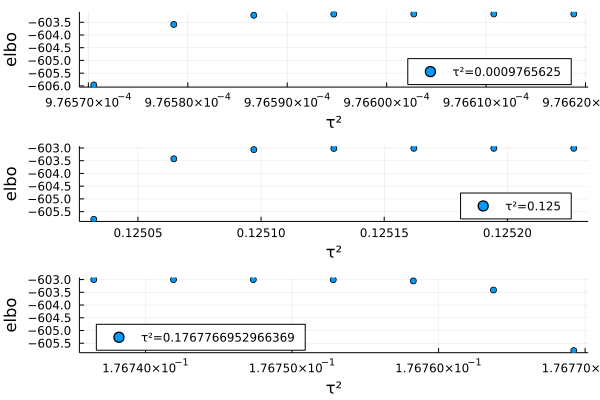

In [97]:
l3=@layout[a; b;c]
pp4=scatter(tg1[:,1],tg1[:,2],label="τ²=$(τ²[1])", xlab="τ²", ylab="elbo",legend=:bottomright)
pp5=scatter(tg15[:,1],tg15[:,2],label="τ²=$(τ²[15])", xlab="τ²", ylab="elbo",legend=:bottomright)
pp6=scatter(tg16[:,1],tg16[:,2],label="τ²=$(τ²[16])", xlab="τ²", ylab="elbo",legend=:bottomleft)
plot(pp4,pp5,pp6,layout=l3)

The following case hard to recognize how elbo changes when τ² reaches the true `τ2=0.1`, so that the first and second halves are separated to display.  The middle plot shows increase to the max elbo after decrease from the large initial value.

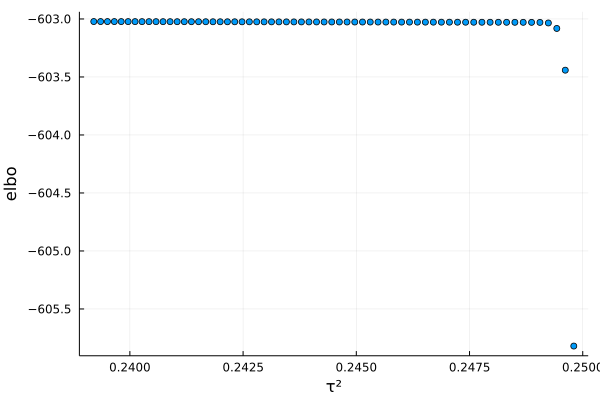

In [100]:
r1=scatter(tg17[:,1],tg17[:,2],label="", xlab="τ²", ylab="elbo") 
# r=plot(tg17[1:250,1],tg17[1:250,2],label="", xlab="τ²", ylab="elbo") 
# r2=plot(tg17[251:end,1],tg17[251:end,2],label="τ²=$(τ²[17])", xlab="τ²", ylab="elbo")
# plot(r1,r2,r,layout=@layout[a; b; c])
r1

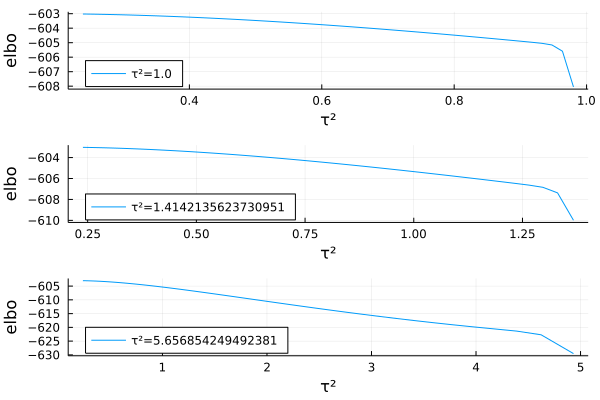

In [103]:
pp10=plot(tg2[:,1],tg2[:,2],label="τ²=$(τ²[end-5])",xlab="τ²", ylab="elbo",legend=:bottomleft)
pp8= plot(tg0[:,1],tg0[:,2],label="τ²=$(τ²[end-4])",xlab="τ²", ylab="elbo",legend=:bottomleft)
pp9=plot(tg[:,1],tg[:,2],label="τ²=$(τ²[end])",xlab="τ²", ylab="elbo",legend=:bottomleft)
plot(pp10,pp8,pp9,layout=@layout[a; b; c])

## Testing power

Based on examples above, picking a `large` enough initial value for hyper-parameter, `τ²` obtains optimal elbo.  Modified the initial value τ² set to be sufficiently large (1.99) in the glmm function and ran 100 simulations to test power of the score test.  Null data sets include τ²K (empirical grm) only, and alternative datasets adds a signal (`b_true`) to the null data sets.  

In [261]:
R=100; τ2=τ²[18] # true τ²

0.3535533905932738

In [262]:
b_true=zeros(p); 
b_1s=zeros(R); 
init0=[]; init1=[]
Ts=zeros(p,R);
 tt=zeros(R);
#Ps=zeros(p,R); 
 Ts1=zeros(p,R);#Ps1=zeros(p,R);

for j = 1:R
    b_true[1]= randn(1)[1] # true b 
    b_1s[j] = b_true[1]   
   
# data generation
    g=rand(MvNormal(τ2*K0)) #grm
    
    Y= logistic.(g) .>rand(n) # H0 data
    Y1=logistic.(X1*b_true+g) .>rand(n)  # H1 data
    
    Y=convert(Vector{Float64},Y)
    Y1=convert(Vector{Float64},Y1) 
    
    # Y0[:,j]=Y1
# test power
    t0=@elapsed begin
        # implementing null glmm
        Xt, Xt₀, yt,init00= initialization(Y,X1,ones(n,1),T,S;tol=1e-4) #H0 data
        Xt, Xt₀, yt,init10= initialization(Y1,X1,ones(n,1),T,S;tol=1e-4)#H1 data    
       # compute test statistics
        T0= computeT(init00,yt,Xt₀,Xt)
        T1= computeT(init10,yt,Xt₀,Xt)
    end
    init0=[init0;init00]
    init1=[init1;init10]
    Ts[:,j]=T0;
    Ts1[:,j]=T1
    # # Ps[:,j]=ccdf.(Chisq(1),T0); Ps1[:,j]=ccdf.(Chisq(1),T1)
    tt[j]=t0
  
end

1186
731
473
684
898
796
931
948
1076
725
630
457
781
565
582
770
910
624
533
486
1095
833
683
538
1338
808
931
597
955
800
361
357
992
733
1108
487
1028
677
948
1073
865
1018
799
586
503
790
962
814
1104
565
940
519
1097
787
579
485
596
937
862
450
565
494
770
529
543
492
1102
810
655
835
683
603
1126
712
732
625
1040
679
777
569
910
770
608
711
930
885
764
681
1266
519
707
533
1125
1175
1091
618
793
835
676
571
366
832
591
759
848
598
1227
619
1241
676
1041
743
750
738
1049
591
932
530
739
503
1043
627
743
1170
888
629
1380
469
775
628
638
883
832
591
912
591
1165
482
562
496
971
1056
1009
516
574
899
376
625
697
717
1130
611
942
710
1034
870
478
757
798
1147
465
1120
629
794
734
1074
840
367
659
893
1066
1017
1247
655
664
892
389
567
662
520
564
823
485
720
900
893
783
474
1075
432
736
1011
935
789
1004
696
832
565
895
724


In [285]:
j=1
    b_true[1]= randn(1)[1] # true b 
 
   
# data generation
    g=rand(MvNormal(τ2*K0)) #grm
    
    Y= logistic.(g) .>rand(n) # H0 data
    Y1=logistic.(X1*b_true+g) .>rand(n)  # H1 data
    

503-element BitVector:
 0
 1
 0
 1
 1
 1
 0
 0
 1
 0
 0
 1
 1
 ⋮
 1
 0
 0
 0
 0
 0
 1
 1
 1
 0
 0
 0

In [288]:
τ2

0.3535533905932738

In [274]:
τ2 # true value

0.3535533905932738

In [273]:
tau0=[init0[j].τ2 for j=1:R];
tau1=[init1[j].τ2 for j=1:R];

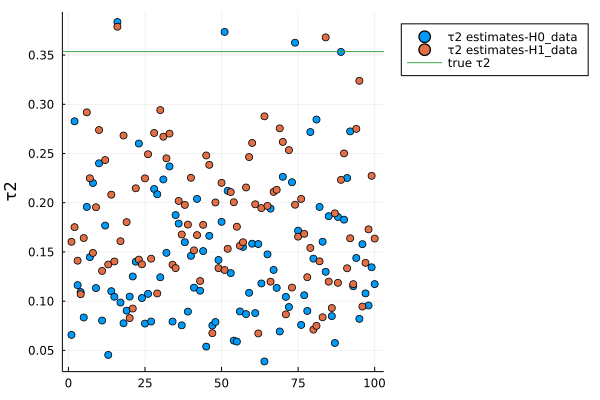

In [278]:
scatter(tau0, ylab="τ2", label="τ2 estimates-H0_data", legend=:outertopright)
scatter!(tau1, label="τ2 estimates-H1_data")
hline!([τ2],label="true τ2")

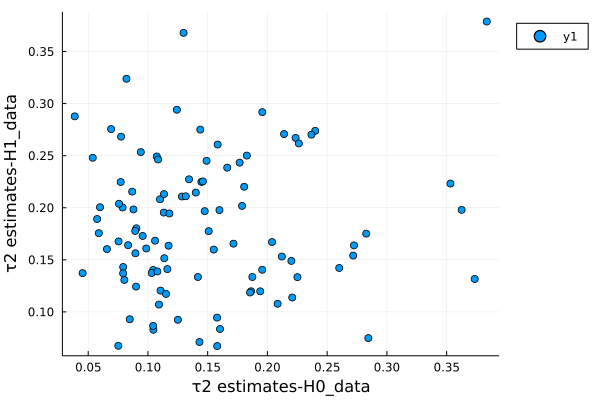

In [280]:
scatter(tau0,tau1,xlab="τ2 estimates-H0_data",ylab="τ2 estimates-H1_data",legend=:outertopright)

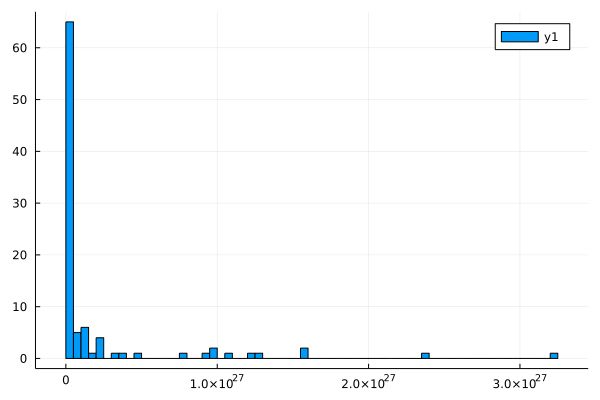

In [284]:
histogram(Ts[1,:])

In [271]:
α=percentile(Ts[1,:],95) # test-statistic at 5% level

1.2097102478301233e27

In [272]:
sum(Ts1[1,:].>α)  # power

16

In [289]:
b_1s

100-element Vector{Float64}:
 -0.8580334885360493
 -0.03311152688512059
  0.42849254495718797
  1.4459420924929385
 -1.3225395784795506
  0.022478719440333993
  0.3720366398677066
 -0.7690329961500612
 -0.22437977373663875
  1.880415887433161
 -2.8700198615344115
  0.2895840835542911
 -2.6254486732897186
  ⋮
 -1.27341734156948
 -1.6451434311991537
  0.16345215645357544
 -1.7412574027524859
 -0.0433876571762539
  0.09584930247929854
 -1.2681787796842168
 -0.5180926757149501
  0.7123133059694813
  1.003472947521368
 -1.7569245508360245
  0.8239611394379063